https://www.datacamp.com/tutorial/random-forests-classifier-python
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [1]:
import pandas as pd
from itertools import product
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
original = pd.read_csv('train.csv')


In [3]:
training_Y = original['Danceability']
original.drop(['Danceability'], axis=1, inplace=True) 

In [4]:
def fillOptions(data, option = 'max'):
    if data.isna().sum() != len(data):
        if option == 'max':
            return data.value_counts().idxmax()
        elif option == 'mean':
            return data.mean()
        elif option == 'median':
            return data.median()

In [5]:
def verifyID(original, newData):
    noInNewData = original[~original['id'].isin(newData['id'])]
    return pd.concat([newData, noInNewData], ignore_index=True)   

In [6]:
def filterArtistComposerDance(data, nameColumnFill):

    listArtist = data['Artist'].unique()
    listComposer = data['Composer'].unique()
    
    filter = list(product(listArtist, listComposer))

    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        artist, composer = i[0], i[1]
        filterData = data[(data['Artist'] == artist) & (data['Composer'] == composer) ]
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)
    return newData

In [7]:
def filterArtist(data, nameColumnFill):
    listDance = data['Artist'].unique()
    filter = listDance


    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        dance = i
        filterData = data[ (data['Artist'] == dance)]
    
    
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)

    return newData

In [8]:
def filterFillData(data, nameColumnFill):
    if not data.isnull().any().any():
        return data
    else:
        for nameColumn in nameColumnFill:
            fillInfo = fillOptions(data[nameColumn], option = 'max')
            if fillInfo != None:
                data.loc[:,nameColumn].fillna(fillInfo, inplace=True)
    return data



In [9]:
def dataPreprocessing(original):
    
    pd.options.mode.chained_assignment = None

    data = original.copy()

    nameColumnFill = ['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Duration_ms', 'Views', 'Likes', "Stream" , "Comments"]

    # License and official_video
    data['Licensed'].fillna(data['official_video'], inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['official_video'].fillna(data['Licensed'], inplace=True)
    data['official_video'].fillna(False, inplace=True)

    data['official_video'].fillna(False, inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['Licensed'].replace({True: 1, False: 0})
    data['official_video'].replace({True: 1, False: 0})

    # Create new class = 'Unknown'
    data['Composer'].fillna("Unknown", inplace=True)
    data['Artist'].fillna("Unknown", inplace=True)
    data['Album_type'].fillna("Unknown", inplace=True)

    

    newData = filterArtistComposerDance(data, nameColumnFill)
    data = newData.copy()

    newData = filterArtist(data, nameColumnFill)
    data = newData.copy()

    newData = filterFillData(data, nameColumnFill)
    data = newData.copy()

    #Transform type key to use as class
    data['Key'] = data['Key'].astype(int)
    data['Key'] = data['Key'].astype(str)

    data = data.sort_values('id')

    # DELETE Track, Album, Uri, Url_spotify, Url_youtube, Description, Title, Channel, id, Comments
    data.drop(['Track', 'Album', 'Uri', 'Url_spotify', 'Url_youtube', 'Description', 'Title', 'Channel', 'id'], axis=1, inplace=True)

    pd.options.mode.chained_assignment = 'warn'

    return data
    


In [10]:
def convertEncoderPD(data, prefix = 'key'):
    titleKeys = []
    for i in range(data.shape[1]):
        titleKeys.append(f'{prefix}_{i}')
    
    return pd.DataFrame(data=data, columns= titleKeys)


In [11]:
def createEncodeDataTraining(data):

    encoderKey = OneHotEncoder()
    encodedKey = encoderKey.fit_transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = OneHotEncoder()
    encodedKeyAlbumType = encoderAlbumType.fit_transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = OneHotEncoder()
    encodedKeyComposer = encoderComposer.fit_transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = LabelEncoder()
    encodedArtist = encoderArtist.fit_transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = StandardScaler()
    scaledData = scaler.fit_transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return {"key": encoderKey, 'AlbumType': encoderAlbumType, 'Composer': encoderComposer, "Artist":encoderArtist} , scaler, data, scaledData_pd
    

In [12]:
def createEncodeDataTesting(encoder, scalerStandard, data):

    encoderKey = encoder['key']
    encodedKey = encoderKey.transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = encoder['AlbumType']
    encodedKeyAlbumType = encoderAlbumType.transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = encoder['Composer']
    encodedKeyComposer = encoderComposer.transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = encoder['Artist']
    encodedArtist = encoderArtist.transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = scalerStandard
    scaledData = scaler.transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return data, scaledData_pd

In [13]:
data = dataPreprocessing(original)

In [14]:
encoders, scalerStandard, data, scaledData_pd = createEncodeDataTraining(data)

c:\Users\user\anaconda3\envs\fintech\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
test = pd.read_csv('test.csv')
dataTest = dataPreprocessing(test)
testOriginal, testScaled = createEncodeDataTesting(encoders, scalerStandard, dataTest)

c:\Users\user\anaconda3\envs\fintech\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
scaledData_pd

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Stream,Licensed,official_video,Comments,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,AlbumType_0,AlbumType_1,AlbumType_2,AlbumType_3,Composer_0,Composer_1,Composer_2,Composer_3,Composer_4,Composer_5,Composer_6,Composer_7,Composer_8,Composer_9,Composer_10,Artist
0,-1.398009,-3.751298,-0.478774,2.622749,-0.263525,-0.277188,-0.770495,-1.255897,-0.929988,-0.152250,-0.281016,-0.449627,-1.525410,-1.783728,-0.110374,-0.354202,-0.342958,-0.472989,-0.327151,5.774080,-0.262265,-0.280814,-0.264415,-0.363302,-0.265799,-0.313108,-0.418596,0.808889,-0.173009,-0.526991,-0.460961,-0.068847,-0.350022,-0.374004,-0.277785,-0.268302,-0.239167,-0.088689,-0.416287,2.390037,-0.316015,0.091884
1,-0.634465,-1.286495,-0.580595,2.397207,4.845583,0.030312,0.893809,0.944228,-0.447282,-0.352389,-0.363223,-0.485495,-1.525410,-1.783728,-0.125275,2.823250,-0.342958,-0.472989,-0.327151,-0.173188,-0.262265,-0.280814,-0.264415,-0.363302,-0.265799,-0.313108,-0.418596,0.808889,-0.173009,-0.526991,-0.460961,-0.068847,2.856960,-0.374004,-0.277785,-0.268302,-0.239167,-0.088689,-0.416287,-0.418404,-0.316015,-0.726161
2,0.195801,-1.682721,-0.479762,2.377255,4.604147,-0.268505,-0.606524,-1.205320,-0.645164,-0.352389,-0.363223,-0.452510,-1.525410,-1.783728,-0.125275,2.823250,-0.342958,-0.472989,-0.327151,-0.173188,-0.262265,-0.280814,-0.264415,-0.363302,-0.265799,-0.313108,-0.418596,-1.236263,5.780036,-0.526991,-0.460961,-0.068847,-0.350022,-0.374004,-0.277785,-0.268302,-0.239167,-0.088689,-0.416287,2.390037,-0.316015,0.942651
3,-0.529179,0.335114,-0.642875,-0.505931,-0.263873,-0.275451,-0.069520,0.995715,0.348878,0.494190,0.252463,1.207829,0.655562,0.560624,-0.002817,-0.354202,-0.342958,2.114213,-0.327151,-0.173188,-0.262265,-0.280814,-0.264415,-0.363302,-0.265799,-0.313108,-0.418596,0.808889,-0.173009,-0.526991,2.169381,-0.068847,-0.350022,-0.374004,-0.277785,-0.268302,-0.239167,-0.088689,-0.416287,-0.418404,-0.316015,0.746320
4,0.073990,0.619057,-0.659680,-0.522406,-0.261251,-0.258129,-0.954963,-0.763974,0.339028,0.972284,0.439960,-0.470537,0.655562,0.560624,0.031552,2.823250,-0.342958,-0.472989,-0.327151,-0.173188,-0.262265,-0.280814,-0.264415,-0.363302,-0.265799,-0.313108,-0.418596,0.808889,-0.173009,-0.526991,-0.460961,-0.068847,-0.350022,-0.374004,-0.277785,-0.268302,-0.239167,-0.088689,-0.416287,2.390037,-0.316015,1.138982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17165,1.896767,0.315032,-0.592458,-0.131894,-0.263873,-0.279136,0.533073,-1.033371,-1.132043,-0.121606,-0.365754,0.011762,0.655562,0.560624,-0.125891,-0.354202,2.915808,-0.472989,-0.327151,-0.173188,-0.262265,-0.280814,-0.264415,-0.363302,-0.265799,-0.313108,-0.418596,0.808889,-0.173009,-0.526991,-0.460961,-0.068847,-0.350022,-0.374004,-0.277785,3.727142,-0.239167,-0.088689,-0.416287,-0.418404,-0.316015,-0.726161
17166,2.004703,1.299226,0.674876,-0.522324,-0.263873,-0.277374,0.528974,1.826279,-0.643512,-0.352473,-0.365192,-0.489278,0.655562,0.560624,-0.125891,-0.354202,-0.342958,2.114213,-0.327151,-0.173188,-0.262265,-0.280814,-0.264415,-0.363302,-0.265799,-0.313108,-0.418596,0.808889,-0.173009,-0.526991,-0.460961,14.524989,-0.350022,-0.374004,-0.277785,-0.268302,-0.239167,-0.088689,-0.416287,-0.418404,-0.316015,-0.431665
17167,0.974288,0.674550,-0.277107,-0.272629,-0.263873,-0.251575,-0.446653,1.607898,-0.765362,-0.353013,-0.366241,0.191422,0.655562,0.560624,-0.125891,-0.354202,-0.342958,-0.472989,-0.327151,-0.173188,-0.262265,3.561078,-0.264415,-0.363302,-0.265799,-0.313108,2.388939,-1.236263,-0.173009,-0.526991,-0.460961,-0.068847,-0.350022,-0.374004,-0.277785,-0.268302,-0.239167,-0.088689,-0.416287,-0.418404,3.164407,1.138982
17168,0.473816,-0.861336,3.225361,-0.326461,-0.263873,-0.273113,0.045260,1.169517,-1.012757,-0.353135,-0.327221,-0.506846,

In [17]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(scaledData_pd, training_Y, test_size = 0.20, random_state = 123)

### RandomForestRegressor

In [18]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
import pickle

# Instantiate model with 1000 decision trees
# rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# # Train the model on training data
# rf.fit(train_features, train_labels)

# filename = "random_forest_regressor.joblib"
# pickle.dump(rf, open(filename, "wb"))

In [19]:
# # Use the forest's predict method on the test data
# predictions = rf.predict(test_features)
# # Calculate the absolute errors
# predictions = np.rint(predictions)
# errors = abs(predictions - test_labels)
# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2))

In [20]:
# Use the forest's predict method on the test data
# predictionsTest = rf.predict(testScaled)
# predictionsTest = np.rint(predictionsTest)


In [21]:
# predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
# predictionTest_pd.to_csv('RandomForestRegressor.csv')

In [22]:
# # load model
# loaded_model = pickle.load(open(filename, "rb"))
# # you can use loaded model to compute predictions
# predicted = loaded_model.predict(test_features)

# predicted = np.rint(predicted)
# errors = abs(predicted - test_labels)
# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2))

# XGBOOST

In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
best_params = {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.4, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 30, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'random_state': 0}
default_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 0,
    'n_jobs': -1
}

best_model = XGBRegressor(**default_params)
best_model.fit(train_features, train_labels)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [24]:

preds = best_model.predict(test_features)
mae = mean_absolute_error(test_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.7788469836949932


In [49]:
best_model.feature_importances_

array([0.07953271, 0.04373069, 0.15077144, 0.12241074, 0.02864805,
       0.033625  , 0.2406988 , 0.1124711 , 0.03987774, 0.02369307,
       0.03086624, 0.01724709, 0.        , 0.        , 0.02484345,
       0.00708216, 0.        , 0.00632974, 0.00962815, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00908882, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00713798,
       0.        , 0.        , 0.        , 0.00769392, 0.        ,
       0.        , 0.00462316], dtype=float32)

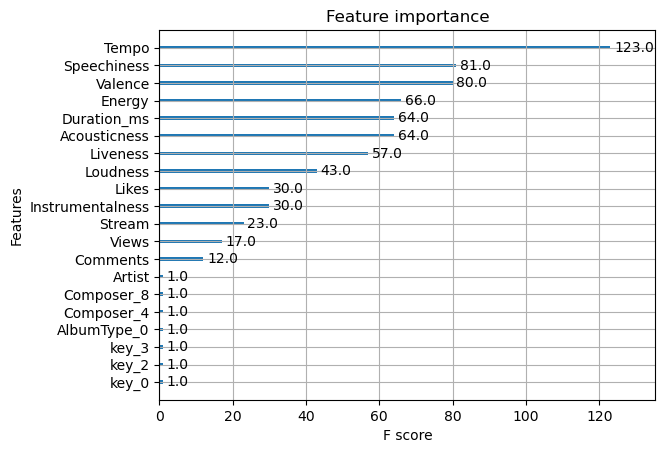

In [50]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(best_model)
pyplot.show()

In [27]:
# Use the forest's predict method on the test data
predictionsTest = best_model.predict(testScaled)
predictionsTest = np.rint(predictionsTest)
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('XGB.csv')


In [35]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)

# ADABOOST

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
base_estimator = DecisionTreeRegressor(max_depth=3, splitter='best', min_samples_split=2)
model = AdaBoostRegressor(base_estimator=base_estimator,n_estimators=500, random_state=42) #n_estimators = 1000, random_state = 42
model.fit(train_features, train_labels)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=500, random_state=42)

In [48]:

preds = model.predict(test_features)
mae = mean_absolute_error(test_labels, preds)
print(f"MAE without CV: {mae}")
# does worse

MAE without CV: 2.0934357062130737


# LIGHTGBM

In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'num_leaves': 40,
              'learning_rate': 0.1,
              'feature_fraction': 0.9
              }
gbm = lgb.train(params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train','valid'],
   )